In [312]:
import requests
from pprint import pprint
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer
from string import punctuation
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ArsOley\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ArsOley\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [296]:
TOKEN = '031a725e031a725e031a725e4f036b22a00031a031a725e5dbaea87ddbb6f8fc8545cd8'
group = '-29534144' #Лентач
version = '5.103'
STOPWORDS = stopwords.words('russian')
morph = MorphAnalyzer()

In [297]:
data = requests.get(
    'https://api.vk.com/method/wall.get', 
    params={
        "owner_id": group,
        "count": 20,
        "v":"5.92",
        "access_token": TOKEN
        
    }
).json()
post_ids = [x['id'] for x in data['response']['items']]

In [298]:
post_ids

[14334372,
 14334474,
 14334200,
 14334054,
 14333925,
 14333767,
 14333656,
 14333527,
 14333440,
 14333282,
 14333185,
 14333036,
 14332894,
 14332833,
 14332544,
 14332319,
 14332193,
 14331991,
 14331795,
 14331439]

In [299]:
comments = []
offsets = list(range(0, 1000, 100))

for post_id in post_ids:
    for off in offsets:
        data = requests.get(
            'https://api.vk.com/method/wall.getComments',
            params={
                'owner_id': group,
                'post_id': post_id,
                'access_token': TOKEN,
                'v': version,
                'offset': off,
                'need_likes': 1,
                'count': 100,
                'thread_items_count': 10
            }
        ).json()
        comments.extend(data['response']['items'])
        for comment in data['response']['items']:
            if comment['thread']['count'] != 0:
                comments.extend(comment['thread']['items'])

In [302]:
for i in range(len(comments)):
    if 'from_id' not in comments[i]:
        del comments[i]
len(comments)

1451

In [303]:

users = set([x['from_id'] for x in comments])
len(users)


815

In [304]:
comments_metadata = []
for i in comments:
    comment = {
        'user_id': i['from_id'],
        'text': i['text'],
        'likes_count': i['likes']['count']
    }
    comments_metadata.append(comment)

In [305]:
comments_df = pd.DataFrame.from_dict(comments_metadata)
comments_df

,user_id,text,likes_count
0,14301570,"Лентач, который уже 3 год подряд берет огромны...",211
1,290562,"Это война, чё вы хотели",2
2,196202102,Только представьте сколько людей сидят и ставя...,40
3,7351481,"Странно, что лентач царя не рисует",1
4,185367764,Переделайте разметку под : лентач x 89squad,0
...,...,...,...
1446,614645911,"[id17155502|Павел], »""где медицина развита мен...",8
1447,17155502,Щас бы в 2020к еще спорить на тему развитости ...,2
1448,614645911,"[id17155502|Павел], зачем ты сам себя лайкашь ...",2
1449,102288260,"[id30307910|Александр], а поновее ничего нет?",2


In [306]:
def get_user_info(user_id):
    if user_id < 0:
        return 'None', 'None'
    user_data = requests.get(
        'https://api.vk.com/method/users.get',
        params={
            'user_ids': user_id,
            'fields': 'sex, bdate',
            'access_token': TOKEN,
            'v': version,
        }
    ).json()
    if user_data['response'][0]['sex'] == 1:
        user_sex = 'f'
    elif user_data['response'][0]['sex'] == 2:
        user_sex = 'm'
    elif user_data['response'][0]['sex'] == 0:
        user_sex = 'None'
    if 'bdate' not in user_data['response'][0]:
        user_age = 'None'
    else:
        user_bdate = user_data['response'][0]['bdate'].split('.')
        if len(user_bdate) == 3:
            user_age = 2020 - int(user_data['response'][0]['bdate'].split('.')[2])
        else:
            user_age = 'None'
    
    return user_sex, user_age

In [307]:
users_info = comments_df['user_id'].apply(get_user_info)
users_info

0         (m, 26)
1         (m, 34)
2       (f, None)
3         (m, 27)
4         (m, 19)
          ...    
1446     (m, 118)
1447      (m, 31)
1448     (m, 118)
1449    (m, None)
1450      (m, 33)
Name: user_id, Length: 1451, dtype: object

In [308]:
users_sex = users_info.apply(lambda x: x[0])
users_age = users_info.apply(lambda x: x[1])
users_age


0         26
1         34
2       None
3         27
4         19
        ... 
1446     118
1447      31
1448     118
1449    None
1450      33
Name: user_id, Length: 1451, dtype: object

In [309]:
comments_df['user_sex'] = users_sex
comments_df['user_age'] = users_age
comments_df

,user_id,text,likes_count,user_sex,user_age
0,14301570,"Лентач, который уже 3 год подряд берет огромны...",211,m,26
1,290562,"Это война, чё вы хотели",2,m,34
2,196202102,Только представьте сколько людей сидят и ставя...,40,f,None
3,7351481,"Странно, что лентач царя не рисует",1,m,27
4,185367764,Переделайте разметку под : лентач x 89squad,0,m,19
...,...,...,...,...,...
1446,614645911,"[id17155502|Павел], »""где медицина развита мен...",8,m,118
1447,17155502,Щас бы в 2020к еще спорить на тему развитости ...,2,m,31
1448,614645911,"[id17155502|Павел], зачем ты сам себя лайкашь ...",2,m,118
1449,102288260,"[id30307910|Александр], а поновее ничего нет?",2,m,None


In [310]:
def comment_text_lemmatize(text):
    if re.search(r'\[.+?\|(.+?)\]', text):
        addressee = re.search(r'\[.+?\|(.+?)\]', text).group(1)
        text = re.sub(r'\[.+?\|.+?\]', addressee, text)

    text = [x.strip(punctuation).lower() for x in word_tokenize(text) if x.isalpha() and (x not in STOPWORDS)]
    text_lemmatized = ' '.join([morph.parse(x)[0].normal_form for x in text])
    
    return text_lemmatized

In [313]:
texts_lemmatized = comments_df['text'].apply(comment_text_lemmatize)
texts_lemmatized


0       лентач который год подряд брать огромный кусок...
1                                    это война что хотеть
2       только представить сколько человек сидеть став...
3                            странно лентач царь рисовать
4                            переделать разметка лентач x
                              ...                        
1446    павел медицина развить менее тот европа юродив...
1447    сейчас спорить тема развитость медицина запад ...
1448    павел лайкать квасной клоунский пост волшебный...
1449                                      александр новый
1450                           сергей сам пить свой пойло
Name: text, Length: 1451, dtype: object

In [314]:
comments_df['text_lemmatized'] = texts_lemmatized
comments_df

,user_id,text,likes_count,user_sex,user_age,text_lemmatized
0,14301570,"Лентач, который уже 3 год подряд берет огромны...",211,m,26,лентач который год подряд брать огромный кусок...
1,290562,"Это война, чё вы хотели",2,m,34,это война что хотеть
2,196202102,Только представьте сколько людей сидят и ставя...,40,f,None,только представить сколько человек сидеть став...
3,7351481,"Странно, что лентач царя не рисует",1,m,27,странно лентач царь рисовать
4,185367764,Переделайте разметку под : лентач x 89squad,0,m,19,переделать разметка лентач x
...,...,...,...,...,...,...
1446,614645911,"[id17155502|Павел], »""где медицина развита мен...",8,m,118,павел медицина развить менее тот европа юродив...
1447,17155502,Щас бы в 2020к еще спорить на тему развитости ...,2,m,31,сейчас спорить тема развитость медицина запад ...
1448,614645911,"[id17155502|Павел], зачем ты сам себя лайкашь ...",2,m,118,павел лайкать квасной клоунский пост волшебный...
1449,102288260,"[id30307910|Александр], а поновее ничего нет?",2,m,None,александр новый


In [315]:
comments_df.rename(columns={'text': 'text_original'}, inplace=True)
comments_df

,user_id,text_original,likes_count,user_sex,user_age,text_lemmatized
0,14301570,"Лентач, который уже 3 год подряд берет огромны...",211,m,26,лентач который год подряд брать огромный кусок...
1,290562,"Это война, чё вы хотели",2,m,34,это война что хотеть
2,196202102,Только представьте сколько людей сидят и ставя...,40,f,None,только представить сколько человек сидеть став...
3,7351481,"Странно, что лентач царя не рисует",1,m,27,странно лентач царь рисовать
4,185367764,Переделайте разметку под : лентач x 89squad,0,m,19,переделать разметка лентач x
...,...,...,...,...,...,...
1446,614645911,"[id17155502|Павел], »""где медицина развита мен...",8,m,118,павел медицина развить менее тот европа юродив...
1447,17155502,Щас бы в 2020к еще спорить на тему развитости ...,2,m,31,сейчас спорить тема развитость медицина запад ...
1448,614645911,"[id17155502|Павел], зачем ты сам себя лайкашь ...",2,m,118,павел лайкать квасной клоунский пост волшебный...
1449,102288260,"[id30307910|Александр], а поновее ничего нет?",2,m,None,александр новый


In [316]:
comments_df.to_csv('vk_comments.csv', index=False)

In [317]:
comments_df = pd.read_csv('vk_comments.csv')

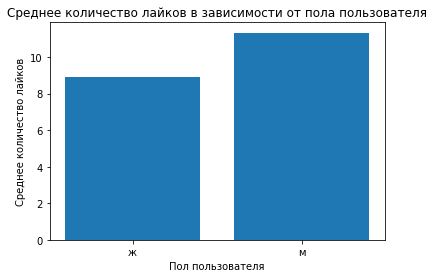

In [318]:
# Правда ли, что комментариям, написанным мужчинами, чаще ставят лайки? Построим bar plot.

female_mean = comments_df[comments_df['user_sex'] == 'f']['likes_count'].mean()
male_mean = comments_df[comments_df['user_sex'] == 'm']['likes_count'].mean()
plt.bar((1, 2), (female_mean, male_mean))
plt.xticks(ticks=(1, 2), labels=('ж', 'м'))
plt.title('Среднее количество лайков в зависимости от пола пользователя')
plt.ylabel('Среднее количество лайков')
plt.xlabel('Пол пользователя')
plt.show()

In [319]:
comments_df['text_lemmatized'].fillna('', inplace=True)
comments_df['text_lemmatized'].isna().sum()

0

In [320]:
lemmatized_texts_len = comments_df['text_lemmatized'].apply(lambda x: len(x.split()))

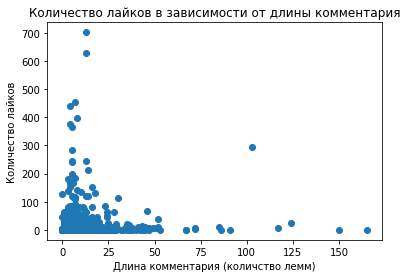

In [321]:
# Правда ли, что коротким комментариям чаще ставят лайки? Построим scatter plot для двух переменных.

lemmatized_texts_len = comments_df['text_lemmatized'].apply(lambda x: len(x.split()))
plt.scatter(lemmatized_texts_len, comments_df['likes_count'])
plt.title('Количество лайков в зависимости от длины комментария')
plt.ylabel('Количество лайков')
plt.xlabel('Длина комментария (количство лемм)')
plt.show()

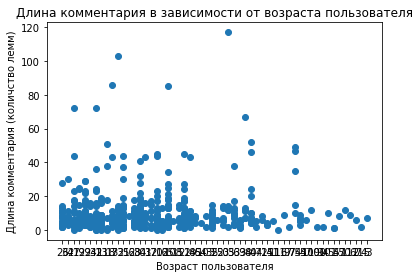

In [328]:
# Правда ли, что пользователи старшего возраста пишут более длинные комментарии? Построим scatter plot для двух переменных.

age_lemmatized_texts_len = comments_df[comments_df['user_age'] != 'None']['text_lemmatized'].apply(lambda x: len(x.split()))

plt.scatter(comments_df[comments_df['user_age'] != 'None']['user_age'], age_lemmatized_texts_len)
plt.title('Длина комментария в зависимости от возраста пользователя')
plt.ylabel('Длина комментария (количство лемм)')
plt.xlabel('Возраст пользователя')
plt.show()

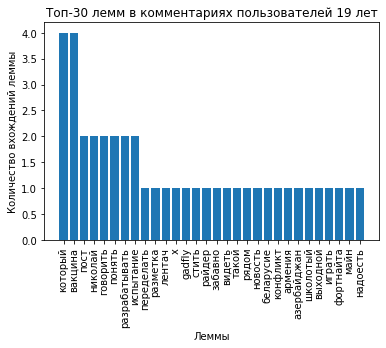

In [330]:
# Узнаем топ-30 лемм в комментариях, написанных ползователями 19 лет.

lemma_19 = []

for i in list(comments_df[comments_df['user_age'] == '19']['text_lemmatized']):
    if i:
        lemma_19.extend(i.split())


lemma_19_count = Counter(lemma_19)

plt.bar(dict(lemma_19_count.most_common(30)).keys(), dict(lemma_19_count.most_common(30)).values())
plt.title('Топ-30 лемм в комментариях пользователей 19 лет')
plt.ylabel('Количество вхождений леммы')
plt.xlabel('Леммы')
plt.xticks(rotation=90)
plt.show()
